# Run grid of single stars

- grid file should include Metallicity, Period, Masses in range 10-150
- in logfile add if wich star is going SN
- Run simulation
- extract table that includes M_ZAMS, M_core-SN, M_env-SN,


In [62]:
import numpy as np
import random
import math
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns



In [98]:
#################################################################
##   Write a grid file to use
#################################################################
proj_dir       = '/Users/lieke/surfdrive/Documents/Winds2/'
loc            = proj_dir + 'output/'
grid_file_name = 'Single_Star_grid.txt'

mass_array = np.arange(10,151, step=1) 
Z          = np.round(0.014/100, 5)
sma        = 50.

container_name = 'SingleStars_Z'+str(Z).replace('.','_')

# Open the output file for writing
with open(loc + grid_file_name, 'w') as f:
    # Write a grid file of len mass_array
    for i in range(len(mass_array)):
        # Set the mass
        m1, m2 = mass_array[i], mass_array[i]
        # write the line
        f.write('--random-seed {} --initial-mass-1 {} --initial-mass-2 {} --metallicity {} --semi-major-axis {} \n'.format(i, m1, m2, Z, sma))


###############################################
###
###############################################
def replaceFileLine(file_dir, line_num, replacestr):
    """
    file_dir   = The file of which you would like to change a line
    line_num   = The line number that you want to change
    replacestr = The string that you want to replace this line wtth
    """
    #Open file of interest
    with open (file_dir, "r") as myfile:
        data = myfile.readlines()
    #Replace line
    data[line_num-1] = replacestr
    # Write everything back
    with open (file_dir, "w") as wfile:
        wfile.writelines(data)


In [99]:
#################################################################
##   Run the job
#################################################################
# change the grid file that is being used
replaceFileLine(loc + "/compasConfig.yaml",176, '    --grid:  \"%s\"'%(grid_file_name) + "\n")
# change the output container
replaceFileLine(loc + "/compasConfig.yaml",180, '    --output-container:  \"%s\"'%(container_name) + "\n")



# Change to the directory you want to execute the command in
os.chdir(loc)

# Run COMPAS
os.system("python runSubmit.py")



0

In [100]:
#################################################################
##   Open the result
#################################################################
from astropy.table import Table, Column, join

######################################
# Read data
with h5py.File(loc + container_name + '/'+container_name+'.h5', 'r') as h5data:

    # Convert to astropy table
    SYS, DCO, SN = Table(), Table(), Table()

    for key in list(h5data['BSE_System_Parameters'].keys()):
        SYS[key] =  h5data['BSE_System_Parameters'][key][()]

    for key in list(h5data['BSE_Supernovae'].keys()):
        SN[key] =  h5data['BSE_Supernovae'][key][()]


######################################
# Select only the 'SEED' and 'Metallicity@ZAMS(1)' columns 
SYS_sub = SYS[['SEED', 'Metallicity@ZAMS(1)']]
# Join the two tables based on the 'SEED' 
SN           = join(SN, SYS_sub, keys='SEED', join_type='left') #left= every row from the left table + matching values from the right '

# Select all the supernova where star 1 is going SN
SN1 = SN[SN['Supernova_State'] == 1 ]

######################################
# Write your new table containing only a selection of the data
sub_SN = SN['SEED', 'Metallicity@ZAMS(1)', 'Mass@ZAMS(SN)', 'Mass_Total@CO(SN)', 'Mass_Core@CO(SN)', 'Mass_CO_Core@CO(SN)', 'Mass_He_Core@CO(SN)', \
           'SystemicSpeed', 'Is_Hydrogen_Poor(SN)', 'Fallback_Fraction(SN)', \
           'Applied_Kick_Magnitude(SN)', 'Drawn_Kick_Magnitude(SN)', 'SN_Kick_Mean_Anomaly(SN)', 'SN_Kick_Phi(SN)', 'SN_Kick_Theta(SN)', 'SN_Orbit_Inclination_Angle']


sub_SN.write(loc + container_name + '/SupernovaData'+str(Z).replace('.','_')+'.h5', format='hdf5', path='BSE_Supernovae')


# Let's inspect the result

In [61]:
######################################
##PLOT setttings
plt.rc('font', family='serif')

from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



0_00014
0_00028
0_0014
0_0028
0_014


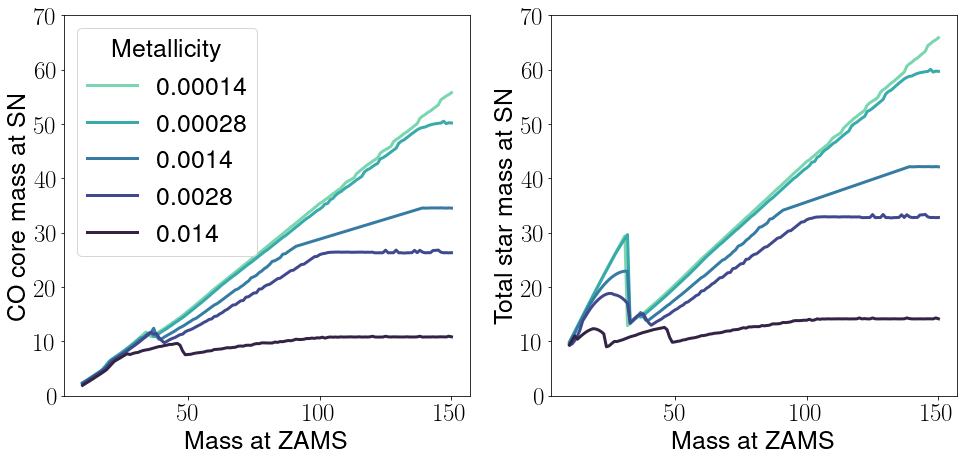

In [101]:
Zsun       = 0.014
metal_list = [np.round(Zsun/x,5) for x in [100., 50., 10., 5., 1.]]
colors     = sns.color_palette("mako", len(metal_list) )[::-1]#mako


fig , ax = plt.subplots(1,2, figsize = (16,7) )

for i, Z in enumerate(metal_list):
    metal_string = str(Z).replace('.','_')
    print(metal_string)
    
    read_dir = loc + 'SingleStars_Z'+metal_string+'/' + 'SupernovaData'+metal_string+'.h5'
    SNtable = Table.read(read_dir, format='hdf5', path='BSE_Supernovae')

    ax[0].plot(SNtable['Mass@ZAMS(SN)'], SNtable['Mass_CO_Core@CO(SN)'], 
             label = SNtable['Metallicity@ZAMS(1)'][0], color = colors[i], lw = 3)
    
#     SNtable.info()
    ax[1].plot(SNtable['Mass@ZAMS(SN)'], SNtable['Mass_Total@CO(SN)'], 
             label = None, color = colors[i], lw = 3)    
    
    
# Plotvalues
for i in range(2):
    ax[i].set_xlabel('Mass at ZAMS')
    ax[i].set_ylim(0,70)
ax[0].set_ylabel('CO core mass at SN')
ax[1].set_ylabel('Total star mass at SN')
ax[0].legend(title = 'Metallicity')
plt.savefig(proj_dir + 'plots/SingleStar_MzamsMCO.pdf')
plt.show()
